# Setup

In [6]:
import numpy as np
import import_ipynb
import matplotlib.pyplot as plt
#%matplotlib widget

import organizing
import loadMSIS
import loadIRI
import EnergyDissipation 
import loadEISCAT
import AuroralPrecipitation as ap

from labellines import labelLine, labelLines
from scipy.integrate import solve_ivp



'''
This is the main file. It is used to start the simulation.
Configuration files from IRI and MSIS models are specified here.
Eiscat data files are specified here.
'''

#configuring printing option
con = organizing.pcfg
con.disable()
print('Printing: ', con.print)

#defining file paths
msis_config = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/msis_old.txt'
iri_config  = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/iri.txt'
chemistry_config = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/Reaction rates.txt'
path_eiscat_data = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Data/'

#setup log directory
setup_ = organizing.setup(msis_config, iri_config, chemistry_config, path_eiscat_data)
log_directory = setup_._log_directory

#load neutroal atmopshere model
[z_msis
 , n_o1_msis
 , n_n2_msis
 , n_o2_msis
 , mass_density
 , temp_n_msis
 , scale_height_msis] = loadMSIS.loadMSIS(log_directory + '/Config/msis_old.txt')

#load ionosphere model
[z_iri     
 , ne_iri    
 , t_neutral 
 , t_ion     
 , t_e       
 , rel_o_p   
 , rel_n_p   
 , rel_h_p   
 , rel_he_p  
 , rel_o2_p  
 , rel_no_p] = loadIRI.loadIRI(log_directory + '/Config/iri.txt')

#replace all negative temperatures (-1 K) in IRI model by MSIS model (up to 115 km height, where Te = Ti = Tn)
t_e[t_e<0]             = temp_n_msis[t_e<0]
t_ion[t_ion<0]         = temp_n_msis[t_ion<0]
t_neutral[t_neutral<0] = temp_n_msis[t_neutral<0]

Printing:  0


In [7]:
#differential flux: energy binning: 
e_bin_lims = np.logspace(2, 2+3, 501)
e_bin_mean = (e_bin_lims[1:] + e_bin_lims[:-1]) / 2

#defining parameters for electron production model
#z_min and z_max set to coincide with limit value of z_radar to prevent odd effects 
#(i.e. large deviations in charge neutrality after time integration)
inc_B = (90-78.2)/180*np.pi #inclination measured from vertical, in radians
z_min = 89704.49896798
z_max = 149809.0984206
res_model = 100
z_sd_min = 0
z_sd_max = 800e3
res_sd = 10

#electron production model
e_prod, z_model = EnergyDissipation.e_production(z_min
                                                 , z_max
                                                 , res_model
                                                 , z_sd_min
                                                 , z_sd_max
                                                 , res_sd
                                                 , e_bin_lims
                                                 , z_msis
                                                 , mass_density
                                                 , inc_B)


0.0


In [8]:
"""
#load EISCAT data
[z_radar_time
 , parameters
 , time
 , az
 , el
 , r_errors ] = loadEISCAT.loadEISCATdata(path_eiscat_data, ['r_h', 'r_param', 'r_time', 'r_az', 'r_el', 'r_error'])

z_radar = z_radar_time[0] #for static measurements, the information in r_h stays the same for all measurement points.
ne_meas = parameters[:, :, 0]
dne_meas = r_errors[:, :, 0]
vel = parameters[:, :, 4]
vel_err = r_errors[:, :, 4]


#conversion to SI units:
z_radar = z_radar*1e3
r_time = time[:,0,3]*3600 + time[:,0,4]*60 + time[:,0,5]

zr_diff = (z_radar[1:]- z_radar[:-1])/2
zr_lim = np.array([*z_radar, z_radar[-1]]) - np.array([zr_diff[0], *zr_diff, -zr_diff[-1]])
#del zr_diff, parameters, r_errors, z_radar_time, az, el, time


#reducing radar measurements to heights specified:
if con.print: 
    filt = z_radar <= z_max
    print(filt)
    print(z_radar[filt])
    print(z_radar[z_radar <= z_max].shape)
    print(z_radar.shape)
    print(ne_meas.shape)
    print(ne_meas[:, filt].shape)
    print(dne_meas.shape)
    print(vel.shape)
    print(vel_err.shape)

filt = z_radar <= z_max

z_radar = z_radar[filt]
ne_meas = ne_meas[:, filt]
dne_meas = dne_meas[:, filt]
vel = vel[:, filt]
vel_err = vel_err[:, filt]
"""

"\n#load EISCAT data\n[z_radar_time\n , parameters\n , time\n , az\n , el\n , r_errors ] = loadEISCAT.loadEISCATdata(path_eiscat_data, ['r_h', 'r_param', 'r_time', 'r_az', 'r_el', 'r_error'])\n\nz_radar = z_radar_time[0] #for static measurements, the information in r_h stays the same for all measurement points.\nne_meas = parameters[:, :, 0]\ndne_meas = r_errors[:, :, 0]\nvel = parameters[:, :, 4]\nvel_err = r_errors[:, :, 4]\n\n\n#conversion to SI units:\nz_radar = z_radar*1e3\nr_time = time[:,0,3]*3600 + time[:,0,4]*60 + time[:,0,5]\n\nzr_diff = (z_radar[1:]- z_radar[:-1])/2\nzr_lim = np.array([*z_radar, z_radar[-1]]) - np.array([zr_diff[0], *zr_diff, -zr_diff[-1]])\n#del zr_diff, parameters, r_errors, z_radar_time, az, el, time\n\n\n#reducing radar measurements to heights specified:\nif con.print: \n    filt = z_radar <= z_max\n    print(filt)\n    print(z_radar[filt])\n    print(z_radar[z_radar <= z_max].shape)\n    print(z_radar.shape)\n    print(ne_meas.shape)\n    print(ne_meas[

In [9]:
#load EISCAT data
[powerp_raw
, powerp_err_raw
, powerp_range_raw
, antenna_el
, time_raw] = loadEISCAT.loadEISCATdata(path_eiscat_data, ['r_pp', 'r_pperr', 'r_pprange', 'r_el', 'r_time'])

if con.print:
    plt.figure()
    plt.plot(powerp_raw.reshape(44, 9, -1)[0], powerp_range_raw.reshape(44, 9, -1)[0], '.', markersize = 1)
    #plt.plot(parameters[0, :, 0], z_radar_time[0])
    plt.xlabel('Power Profile [?]')
    plt.ylabel('Range [km]')
    
if con.print:
    plt.figure()
    plt.plot(powerp_range_raw[0])
    

#reshape 1 data dump into the 9 profiles recorded
powerp       = powerp_raw.reshape(powerp_raw.shape[0]*9, -1)
powerp_err   = powerp_err_raw.reshape(powerp_err_raw.shape[0]* 9, -1)
powerp_range = powerp_range_raw.reshape(powerp_range_raw.shape[0]* 9, -1)
time = time_raw[:,0,3]*3600 + time_raw[:,0,4]*60 + time_raw[:,0,5]

if con.print:
    plt.figure()
    plt.plot(powerp[0], powerp_range[0], '.', markersize = 1)
    #plt.plot(parameters[0, :, 0], z_radar_time[0])
    plt.xlabel('Power Profile [?]')
    plt.ylabel('Range [km]')
    

dt = 0.443904
r_time = np.array([[t + 0*dt,
                    t + 1*dt,
                    t + 2*dt,
                    t + 3*dt,
                    t + 4*dt,
                    t + 5*dt,
                    t + 6*dt,
                    t + 7*dt,
                    t + 8*dt] for t in time]).reshape(time.shape[0]*9)


#convert range into height
powerp_height = powerp_range * np.sin(antenna_el[0]) * 1e3

#select data from relevant heights
z_radar  = powerp_height[(powerp_height<z_max) & (powerp_height>z_min)].reshape(powerp_height.shape[0], -1)[0]
ne_meas  = powerp[(powerp_height<z_max) & (powerp_height>z_min)].reshape(powerp_height.shape[0], -1)
dne_meas = powerp_err[(powerp_height<z_max) & (powerp_height>z_min)].reshape(powerp_height.shape[0], -1)

zr_diff = (z_radar[1:]- z_radar[:-1])/2
zr_lim = np.array([*z_radar, z_radar[-1]]) - np.array([zr_diff[0], *zr_diff, -zr_diff[-1]])

del powerp_raw, powerp_err_raw, powerp_range_raw, time_raw
del powerp, powerp_err, powerp_range, powerp_height, time

In [10]:
z_radar

array([ 90092.27057736,  90867.8137961 ,  91643.35701484,  92418.90023359,
        93194.44345233,  93969.98667107,  94745.52988982,  95521.07310856,
        96296.6163273 ,  97072.15954605,  97847.70276479,  98623.24598353,
        99398.78920228, 100174.33242102, 100949.87563976, 101725.41885851,
       102500.96207725, 103276.50529599, 104052.04851474, 104827.59173348,
       105603.13495222, 106378.67817097, 107154.22138971, 107929.76460845,
       108705.3078272 , 109480.85104594, 110256.39426468, 111031.93748343,
       111807.48070217, 112583.02392091, 113358.56713966, 114134.1103584 ,
       114909.65357714, 115685.19679589, 116460.74001463, 117236.28323337,
       118011.82645212, 118787.36967086, 119562.9128896 , 120338.45610835,
       121113.99932709, 121889.54254583, 122665.08576458, 123440.62898332,
       124216.17220206, 124991.71542081, 125767.25863955, 126542.8018583 ,
       127318.34507704, 128093.88829578, 128869.43151453, 129644.97473327,
       130420.51795201, 1

In [5]:
#setup of ion chemistry
import ionChem

model = ionChem.ionChem(chemistry_config, z_model)

model.assign_densities(z_model
                     , z_msis
                     , n_o1_msis
                     , n_n2_msis
                     , n_o2_msis
                     , z_iri
                     , ne_iri        
                     , rel_o_p   
                     , rel_n_p   
                     , rel_h_p   
                     , rel_he_p  
                     , rel_o2_p  
                     , rel_no_p)

#check for self-consistency
model.check_chargeNeutrality()

model.assign_temperatures(z_iri
                          , t_neutral 
                          , t_ion     
                          , t_e)

#saving the initial state
setup_.datadump(model)



importing Jupyter notebook from ionChem.ipynb


<string>:211: RuntimeWarning: divide by zero encountered in log


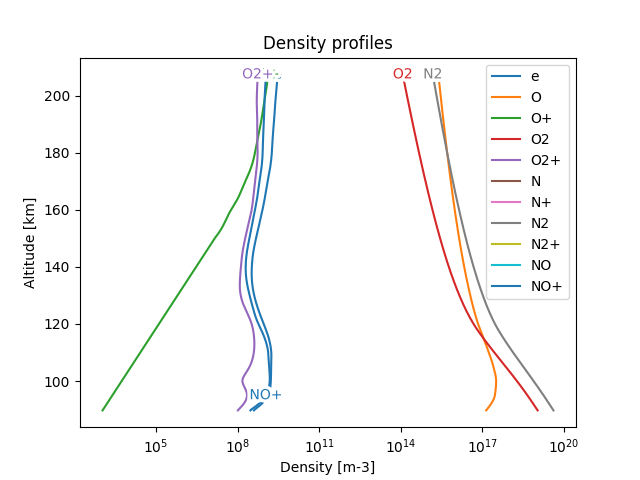

In [6]:
model.plot_density()
#plt.xscale('linear')

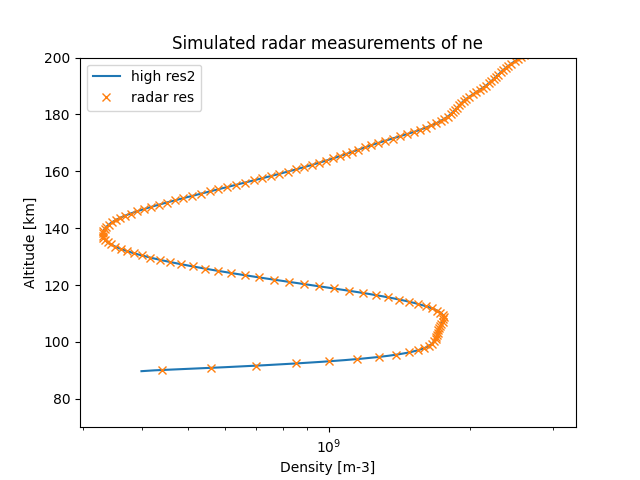

In [7]:
ne_int = np.zeros(len(z_radar))
for i in range(len(z_radar)):
    ne_int[i] = ap.ne_height_int(z_model, model.e.density, zr_lim[i], zr_lim[i+1])
if True:
    plt.figure()
    plt.plot(model.e.density, z_model/1e3, label = 'high res2')
    plt.plot(ne_int, z_radar/1e3, 'x', label = 'radar res')
    plt.legend()
    plt.xscale('log')
    plt.ylim(70, 200)
    plt.title('Simulated radar measurements of ne')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')

In [8]:
#first estimate of electron density, directly assigned to model.el.density (ion model needs to be initiatiated first!)
#using polynomial of 3rd order

#prepping:
e_prod_ps = ap.pulse_smearing_4_e_prod(e_prod, pulse_height = 2000, res = res_model)

eff_recombinationRate = (model.alpha1.r_rate()*model.NOp.density/model.e.density + \
                         model.alpha2.r_rate()*model.O2p.density/model.e.density)

param = [ 1.86421376e+01, -5.16833339e-01,  4.15756160e-03, -8.02510832e-5]

#find first estimate of ne, using steady state, i.e. ne = sqrt(prod / effRR)
result_t0 = ap.find_ne0(param,
                        e_bin_mean, 
                        ne_meas[0], 
                        dne_meas[0], 
                        e_prod_ps, 
                        eff_recombinationRate, 
                        z_model, 
                        zr_lim)


print(result_t0.x)
ne_prod0 = np.dot(e_prod, ap.diff_flux_kev(e_bin_mean, result_t0.x))
ne_mod0  = np.sqrt(ne_prod0/eff_recombinationRate)

if any(ne_prod0 < 0): raise RuntimeError('Negative production')
if any(ne_mod0  < 0): raise RuntimeError('Negative Electron Density')

ne_mod0_radar = np.array([ap.ne_height_int(z_model, ne_mod0, zr_lim[i], zr_lim[i+1]) for i in range(len(z_radar))])
red_chi2 = np.sum((ne_meas[0] -  ne_mod0_radar)**2 / dne_meas[0]**2) / (len(z_radar) - len(result_t0.x))
print(red_chi2)

#in above code, the inversion is performed with pulse-smeared profiles, while chi2 is calculated using unsmeared profiles
# => ????

KeyboardInterrupt: 

57207.95101488101
0.029243172626490475
8.361592267663404
1.0876848476878551


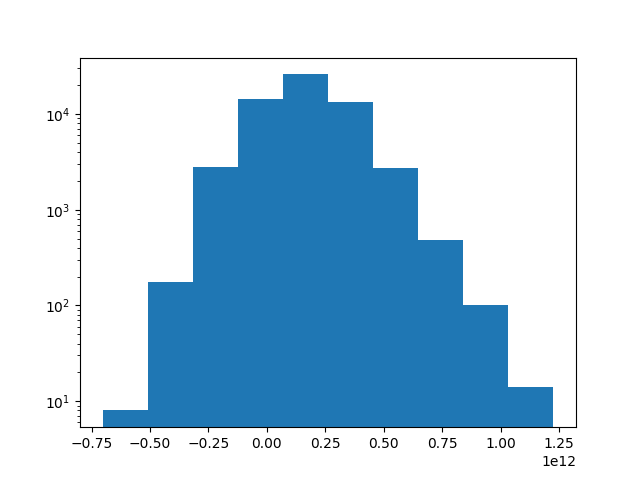

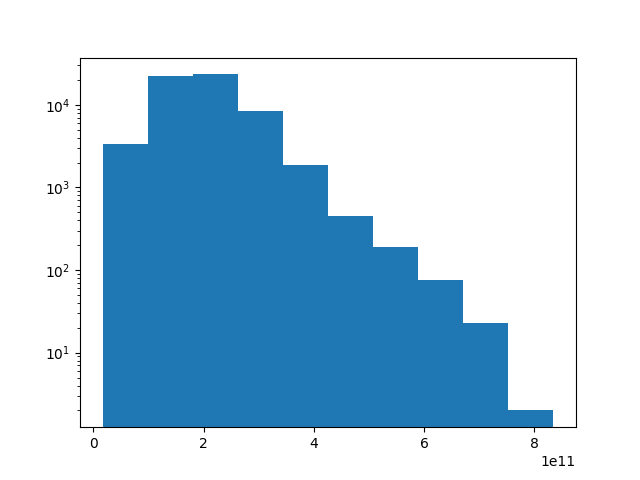

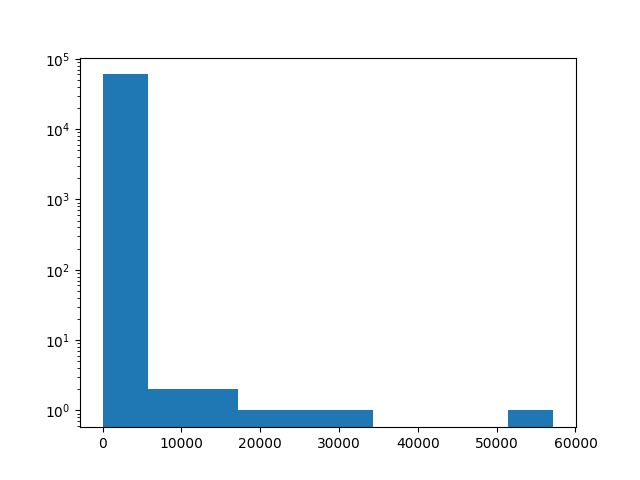

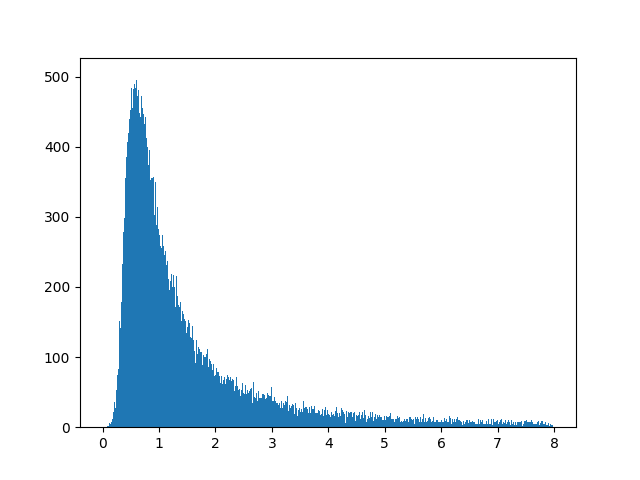

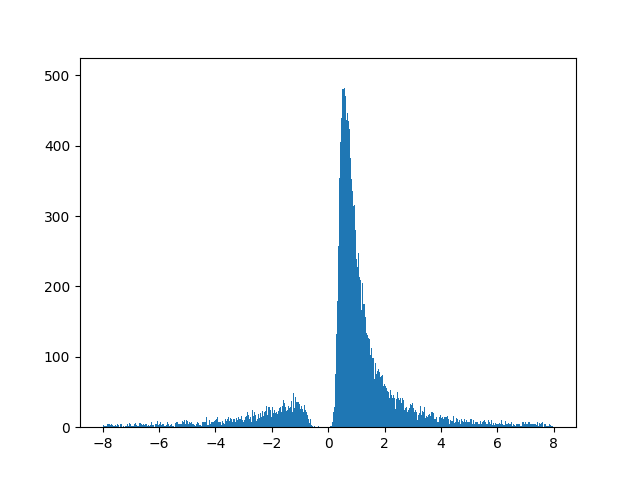

In [45]:
ne_meas.shape
dne_meas.shape

dne_rel = np.abs(dne_meas/ne_meas)


plt.figure()
plt.hist(ne_meas.reshape(-1), log = 'True')


plt.figure()
plt.hist(dne_meas.reshape(-1), log = 'True')


plt.figure()
plt.hist(dne_rel.reshape(-1), log = 'True')

plt.figure()
plt.hist(dne_rel.reshape(-1), bins = np.arange(0, 8, 0.01))

plt.figure()
plt.hist((dne_meas/ne_meas).reshape(-1), bins = np.arange(-8, 8, 0.01))

print(dne_rel.max())
print(dne_rel.min())
print(dne_rel.mean())
print(np.median(dne_rel))

In [ ]:
e_bin_mean 
#what did i want with that?? 

In [ ]:
if con.print:
    plt.figure()
    for j in range(np.int_(e_prod.shape[1]/100)):
        i = j * 100
        #plt.plot(e_prod_ps[:, i], z_model/1e3, label = 'smeared', ls = '--')
        plt.plot(e_prod[:, i], z_model/1e3, label = '%.2f keV' % (e_bin_mean[i]/1e3))    
        plt.legend()
        plt.xscale('log')
        plt.xlabel('Production rate [m^3 s^-1]')
        plt.ylabel('Altitude [km]')

In [ ]:
import matplotlib.colors as colors
plt.figure()
plt.pcolormesh(e_bin_mean/1e3, z_model/1e3, e_prod, norm=colors.LogNorm())
plt.xscale('log')
plt.colorbar()
plt.ylabel('Altidude [km]')
plt.xlabel('Energy [keV]')
#plt.xlim(2e-1, 3e1)

In [ ]:
#ion production:
#could be moved to ionChemistry
p_Op  = ne_prod0 * 0.56 * model.O.density  / (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
p_O2p = ne_prod0 * 1.00 * model.O2.density / (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
p_N2p = ne_prod0 * 0.92 * model.N2.density / (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)

model.e.prod   = ne_prod0
model.Op.prod  = p_Op
model.O2p.prod = p_O2p
model.N2p.prod = p_N2p

plt.figure()
plt.plot(p_Op + p_O2p + p_N2p - ne_prod0, z_model/1e3)
plt.title('Absolute Deviation from charge neutrality')
plt.xlabel('Charge [C]')
plt.ylabel('Altitude [km]')

plt.figure()
plt.plot((p_Op + p_O2p + p_N2p) / ne_prod0, z_model/1e3)
plt.title('Relative Deviation from charge neutrality')
plt.xlabel('[1]')
plt.ylabel('Altitude [km]')



In [ ]:
if con.print:
    param = [ 1.86421376e+01, -5.16833339e-01,  4.15756160e-03, -8.02510832e-5]
    diff_flux = ap.diff_flux_kev(e_bin_mean, param)
    ne_mod    = np.sqrt(np.dot(e_prod, diff_flux)/eff_recombinationRate)
    ne_mod_r  = np.array([ap.ne_height_int(z_model, ne_mod, zr_lim[i], zr_lim[i+1]) for i in range(len(z_radar))])
    
    plt.figure()
    plt.plot(ne_mod, z_model/1e3, label = 'ne')
    plt.legend()
    plt.xscale('log')
    plt.title('Simulated ne')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.xlim(1e11, 1e13)
    
    plt.figure()
    plt.plot(eff_recombinationRate, z_model/1e3, label = 'eff_rr')
    plt.legend()
    plt.xscale('log')
    plt.xlabel('')
    plt.ylabel('Altitude [km]')
    #plt.xlim(1e11, 1e13)
    
    print(ne_mod.shape)
    print(ne_mod[ne_mod > 0].shape)
    print(np.exp(np.log(0)))

In [ ]:
if con.print:
    plt.figure()
    plt.plot(model.Te, z_model/1e3, label = 'Te')
    #plt.plot(model.O2p.density, z_model/1e3, label = 'O2+ density')
    plt.xscale('log')
    plt.legend()
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    ax2 = plt.gca().twiny()
    ax2.plot(eff_recombinationRate, z_model/1e3, '--', label = 'recombintation rate')
    plt.xlabel('Recombination rate')
    plt.xscale('log')
    plt.legend()

    
    plt.figure()
    plt.plot(model.NOp.density, z_model/1e3, label = 'NO+ density')
    plt.plot(model.O2p.density, z_model/1e3, label = 'O2+ density')
    plt.xscale('log')
    plt.legend()
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    ax2 = plt.gca().twiny()
    ax2.plot(eff_recombinationRate, z_model/1e3, '--', label = 'recombintation rate')
    plt.xlabel('Recombination rate')
    plt.xscale('log')
    plt.legend()

    
    plt.figure()
    plt.plot(ne_prod0, z_model/1e3, label = 'ne_prod0')
    plt.ylabel('Density [m-3]')
    plt.xlabel('Altitude [km]')
    plt.xscale('log')
    plt.xlim(1e9, 1e11)
    plt.title('ne_prod for t=0: wiggle investigation')
    plt.legend()
    

In [ ]:
if con.print:
    plt.figure()
    plt.errorbar(ne_meas[0], z_radar/1e3, xerr = dne_meas[0], marker = 'x', linewidth = 0, label = 'ne_meas')
    plt.plot(ne_mod0, z_model/1e3, label = 'ne_mod0')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.xscale('log')
    plt.xlim(1e10, 1e12)
    plt.title('Comparison ne_meas to ne_mod for t=0')
    plt.legend()
    
    plt.figure()
    plt.plot(e_bin_mean, ap.diff_flux_kev(e_bin_mean, param), label = 'starting par')
    plt.plot(e_bin_mean, ap.diff_flux_kev(e_bin_mean, result_t0.x), label = 'min par')
    plt.ylabel('Differential Flux [eV-1 m-2 s-1]')
    plt.xlabel('Energy [eV]')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e6, 1e13)
    plt.legend()


In [ ]:
#check for self-consistency
model.check_chargeNeutrality()
#saving the initial state
setup_.datadump(model)

In [ ]:
#do some testing with ion chemistry, eg only recombinative processes and see how it evovles
#why do i have problmes with charge neutrality for larger timesteps?

In [ ]:
#calculate decay times to find species and altitudes where prod / loss is nearly instantaneous.
#not used at the moment
eff_rr = np.zeros([len(model.all_species), model.n_heights])

for c in model.all_species:
    rr_species = np.zeros([len(model.all_species), model.n_heights], dtype = 'float64')
    
    for r in model.all_reactions:
        if c.c_ID in r.educts_ID:
            #if con.print(): print(r.r_stoch, '\n', c.name, *r.educts[r.educts != c.name], '\n', c.c_ID, *r.educts_ID[r.educts_ID != c.c_ID], '\n')
            [cid2] = r.educts_ID[r.educts_ID != c.c_ID]
            rr_species[cid2] = r.r_rate()*model.all_species[cid2].density
                
    eff_rr[c.c_ID, :] = np.sum(rr_species, axis = 0)

    
filter_ = eff_rr[:, :] > 1 
sum_rows = np.sum(filter_, axis = 0) #number of "instantaneaous" DE per height bin


In [ ]:
con.enable()
%matplotlib widget
model.plot_decayTime()
model.plot_lossRate()

In [ ]:
#to do: check definition of Tr => reduced temperature is something like a mean of the temperature of 2 colliding molecules. since we assume all ion species to have the same temperature, Tn = Ti, always

#check pulse smearing => pulse height


In [ ]:
if con.print:
    plt.figure()
    plt.plot(t_neutral, z_iri/1e3, 'x')
    plt.plot(t_ion[10:], z_iri[10:]/1e3, 'x')
    plt.plot(t_e, z_iri/1e3, 'x')

In [ ]:
#new way to do ionospheric chemistry
#1. take all info from reaction (reaction rate, constituents)
ode_mat = np.zeros((len(model.all_reactions), len(model.all_species)), dtype = 'object')
rrate = np.array([r.r_rate() for r in model.all_reactions])
for r in model.all_reactions:
    e = r.educts_ID
    p = r.products_ID
    ode_mat[r.r_ID, e[0]] = np.array([r.r_ID, -1, *e])
    ode_mat[r.r_ID, e[1]] = np.array([r.r_ID, -1, *e])
    ode_mat[r.r_ID, p[0]] = np.array([r.r_ID,  1, *e])
    ode_mat[r.r_ID, p[1]] = np.array([r.r_ID,  1, *e])
    if p[1] == p[0]: ode_mat[r.r_ID, p[0]] = np.array([r.r_ID,  2, *e])

#2. produce raw DG from 1., excluding all terms that are 0 anyways.
ode_raw = np.empty(len(model.all_species), dtype = 'object')
for i in model.all_species:
#    print(np.array([o for o in ode_mat[:, i.c_ID] if type(o)!= int]))
    ode_raw[i.c_ID] = np.array([o for o in ode_mat[:, i.c_ID] if type(o) != int])
     
#3. produce DG with only relevant terms
def fun(t, n, h):
    n = np.reshape(n, (11, -1))
    dndt = np.array([np.sum(((rrate[ode_raw[i.c_ID][:, 0], h].T  *   ode_raw[i.c_ID][:, 1] ).T\
                                * n[ode_raw[i.c_ID][:, 2], h]    * n[ode_raw[i.c_ID][:, 3], h]   \
                            ), axis = 0) \
                    + i.prod\
                    for i in model.all_species])
    return dndt.reshape(-1)

#production terms are not yet included!!! think about how to include them best!!
        

In [ ]:
import warnings
warnings.simplefilter("default")

with warnings.catch_warnings(record = True) as w:
    warnings.warn("Some warning")
    if w != []:
        for i in w:
            print(i)

In [ ]:
#old code

def fun(t, n, h):
    ode = np.zeros(n.shape)
    
    for c in model.all_species:
        i = c.c_ID
        loss_rr  = np.array(model.loss_table_rr[:, i, h])
        loss_IDs = np.array(model.loss_table_ind[:, i], dtype = int)
        
        prod_rr   = np.array(model.prod_table_rr[:, i, h])
        prod_IDs1 = np.array(model.prod_table_ind[:, i, 1], dtype = int)
        prod_IDs2 = np.array(model.prod_table_ind[:, i, 0], dtype = int)
        
        #loss, prod:
        ode[i] = -np.sum(loss_rr * n[loss_IDs], axis = 0) * n[i] \
                 +np.sum(prod_rr * n[prod_IDs1] * n[prod_IDs2], axis = 0) \
                 +c.prod[h] #constant, unless updated (0 for all except e, O+, O2+ and N2+) 
                # +aurural_prod[i] \
                # +uv_prod[i]
    return ode


def ic():
    res = np.empty(model.n_heights, dtype = 'object')
    
    for h in range(model.n_heights):
        n = np.array([c.density[h] for c in model.all_species])
        res[h] = solve_ivp(fun, (0, dt), n, method='Radau',vectorized=False, args = [h])
        #for j, c in enumerate(model.all_species):
        #    c.density[h] = res[h].y[j, -1]           #replaced by below code:
    
    new_densities = np.array([alt.y[:, -1] for alt in res]).T
    return new_densities

def plot_e_dist(e_bin_mean, param):
    plt.figure()
    plt.plot(e_bin_mean, ap.diff_flux_kev(e_bin_mean, param), label = '1')
    plt.yscale('log')
    plt.legend()


In [ ]:
#first estimate of electron density, directly assigned to model.el.density (ion model needs to be initiatiated first!)
#using polynomial of 3rd order

#prepping:
from scipy.optimize import minimize
import time
import warnings
warnings.simplefilter("default")

def ne_ricatti(t, ne_prod, eff_rr, n0):
    with warnings.catch_warnings(record = True) as w:
        ne = (np.sqrt(ne_prod*eff_rr) * n0+ ne_prod * np.tanh(np.sqrt(ne_prod*eff_rr)*t))/\
               (np.sqrt(ne_prod*eff_rr) + eff_rr * n0 * np.tanh(np.sqrt(ne_prod*eff_rr)*t))
        #if w != []:
        #    print('\n', w[0])
        #    print('n0', n0)
        #    print('ne_prod', ne_prod)
        #    print('eff_rr', eff_rr)
        #    return 0
    return ne

def ne_decay(t, ne_prod, eff_rr, n0):
    return n0 / (1 + n0 * eff_rr * t)

def ne_int(t, ne_prod, eff_rr, n0):
    if any(ne_prod < 1e-300): 
        return np.array([ne_ricatti(t, *i) if i[0]>1e-300 else ne_decay(t, *i) for i in zip(ne_prod, eff_rr, n0)])
    else: return ne_ricatti(t, ne_prod, eff_rr, n0)


def sumofsq_ne(par4diff_flux, e_bin_mean, ne_obs, dne_obs, e_prod_ps, z_model, zr_lim, ne, eff_rr):
    diff_flux = ap.diff_flux_kev(e_bin_mean, par4diff_flux)
    ne_prod = np.dot(e_prod_ps, diff_flux)

    #model.update_production(ne_prod) => do not do that every time!!
    
#      ne_mod    = int_ne(ne_prod, dt, ne, eff_rr)
    ne_0 = model.e.density
    ne_mod = ne_int(dt, ne_prod, eff_rr, ne_0)
    
    ne_mod_r  = np.array([ap.ne_height_int(z_model, ne_mod, zr_lim[i], zr_lim[i+1]) for i in range(len(zr_lim)-1)])
    sumofsq   = np.sum((ne_obs - ne_mod_r)**2/dne_obs**2)
    dphide    = (diff_flux[434:-1] - diff_flux[435:])/(e_bin_mean[434:-1] - e_bin_mean[435:])
    penalty   = np.sum(dphide[dphide>0])
    #if dphide[dphide>0].size > 0: print(dphide[dphide>0])
    return sumofsq + penalty
    
    
def callbackF(xk):
    print(xk)

    
def find_ne(param, e_bin_mean, ne_meas, dne_meas, e_prod_ps, z_model, zr_lim):
    """
    Used for calculating the estimate of ne.
    """
    #minimize
    
    ne = model.e.density
    print('ne', ne)

    eff_rr = (rrate[0]*model.all_species[10].density + \
              rrate[1]*model.all_species[4].density + \
              rrate[2]*model.all_species[8].density)     / ne
    #print('eff_rr', eff_rr)

    result = minimize(sumofsq_ne, 
                         param,
                         #callback = callbackF,
                         method = 'Nelder-Mead',
                         bounds = [(-np.inf, np.inf),(-np.inf, np.inf),(-np.inf, np.inf),(-np.inf, 0)], 
                         #bounds = [(-1e2, 1e2),(-1e2, 1e2),(-1, 1),(-1e-2, -1e-5)], 
                         args=(e_bin_mean, ne_meas, dne_meas, e_prod_ps, z_model, zr_lim, ne, eff_rr)
                         )
    return result

"""good param [ 1.97395039e+01 -1.62058136e+00  2.21111394e-02 -6.81889440e-05]
              [ 1.59239738e+01 -1.24926520e+00  5.46785303e-02 -7.68356934e-04]
   bad  param [-2.31101697e+03  2.42356336e+02  1.72278785e-01 -4.02125565e-01]"""
 

starttime = time.time()

param = result_t0.x
print('p0', param, '\n')
results = np.empty(len(r_time), dtype = 'object')
ne_fit = np.zeros((len(r_time), len(z_model)))
for i, t in enumerate(r_time[1:]):
    laptime = time.time()
    model.prodTable()
    model.lossTable() #check if temperature is actually updated
    results[i] = find_ne(param, e_bin_mean, ne_meas[i+1], dne_meas[i+1], e_prod_ps, z_model, zr_lim)
    #param = results[i].x
    print('param', results[i].x)
    diff_flux = ap.diff_flux_kev(e_bin_mean, results[i].x)
    ne_prod = np.dot(e_prod_ps, diff_flux)
    
    p_Op  = ne_prod * 0.56 * model.O.density  / \
                (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
    p_O2p = ne_prod * 1.00 * model.O2.density / \
                (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
    p_N2p = ne_prod * 0.92 * model.N2.density / \
                (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
        
    model.e.prod   = ne_prod
    model.Op.prod  = p_Op
    model.O2p.prod = p_O2p
    model.N2p.prod = p_N2p
    
    new_densities = ic()
    for j, c in enumerate(model.all_species):
        c.density = new_densities[j]

    ne_fit[i] = model.e.density
    
    #model.check_chargeNeutrality()
    print(i, 'of', len(r_time), 'done.' \
          'Time used:  %.1fm' %((time.time() - laptime)/60), \
          'Total time: %.1fm\n' %((time.time() - starttime)/60))

    #if i == 0: raise KeyboardInterrupt()

#print(result)

"""
ne_prod = np.dot(e_prod, ap.diff_flux_kev(e_bin_mean, result.x))
ne_mod  = np.sqrt(ne_prod/eff_recombinationRate)

if any(ne_prod < 0): raise RuntimeError('Negative production')
if any(ne_mod  < 0): raise RuntimeError('Negative Electron Density')

ne_mod_radar = np.array([ap.ne_height_int(z_model, ne_mod, zr_lim[i], zr_lim[i+1]) for i in range(len(z_radar))])
red_chi2 = np.sum((ne_meas[1] -  ne_mod_radar)**2 / dne_meas[1]**2) / (len(z_radar) - len(result.x))
print(red_chi2)
"""


In [ ]:
param = result_t0.x
plot_e_dist(e_bin_mean, param)

ne = model.e.density

eff_rr = (rrate[0]*model.all_species[10].density + \
              rrate[1]*model.all_species[4].density + \
              rrate[2]*model.all_species[8].density)     / ne

plt.figure()
plt.plot(eff_rr, z_model)

plt.figure()
plt.plot(ne, z_model)

sos = sumofsq_ne(param, e_bin_mean, ne_meas[1], dne_meas[1], e_prod_ps, z_model, zr_lim, ne, eff_rr)
print(sos)

#results[i] = find_ne(param, e_bin_mean, ne_meas[i+1], dne_meas[i+1], e_prod_ps, z_model, zr_lim)

#result = minimize(sumofsq_ne, 
#                         param,
#                         #callback = callbackF,
#                         method = 'Nelder-Mead',
#                         bounds = [(-1e2, 1e2),(-1e2, 1e2),(-1, 1),(-1e-2, -1e-5)], 
#                         args=(e_bin_mean, ne_meas, dne_meas, e_prod_ps, z_model, zr_lim, ne, eff_rr)
#                         )

In [ ]:
result = minimize(sumofsq_ne, 
                         param,
                         #callback = callbackF,
                         method = 'Nelder-Mead',
                         bounds = [(-np.inf, np.inf),(-np.inf, np.inf),(-np.inf, np.inf),(-np.inf, 0)], 
                         args=(e_bin_mean, ne_meas[1], dne_meas[1], e_prod_ps, z_model, zr_lim, ne, eff_rr)
                         )

#results[i] = find_ne(param, e_bin_mean, ne_meas[i+1], dne_meas[i+1], e_prod_ps, z_model, zr_lim)

print(sumofsq_ne(result.x, e_bin_mean, ne_meas[1], dne_meas[1], e_prod_ps, z_model, zr_lim, ne, eff_rr))
print(result.x)
plot_e_dist(e_bin_mean, result.x)


In [ ]:
print(param)
print(result.x)

print(sumofsq_ne(param, e_bin_mean, ne_meas[1], dne_meas[1], e_prod_ps, z_model, zr_lim, ne, eff_rr))
print(sumofsq_ne(result.x, e_bin_mean, ne_meas[1], dne_meas[1], e_prod_ps, z_model, zr_lim, ne, eff_rr))


In [ ]:
diff_flux = ap.diff_flux_kev(e_bin_mean, result.x)
ne_prod = np.dot(e_prod_ps, diff_flux)
plt.figure()
plt.plot(ne_prod, z_model/1e3, label = 'q')
plt.plot(eff_rr * ne**2, z_model/1e3, label = 'l')
plt.xscale('log')
plt.legend()

p_Op  = ne_prod * 0.56 * model.O.density  / \
                (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
p_O2p = ne_prod * 1.00 * model.O2.density / \
            (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
p_N2p = ne_prod * 0.92 * model.N2.density / \
            (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
    
model.e.prod   = ne_prod
model.Op.prod  = p_Op
model.O2p.prod = p_O2p
model.N2p.prod = p_N2p

In [ ]:
def fun(t, n, h):
    ode = np.zeros(n.shape)
    
    for c in model.all_species:
        i = c.c_ID
        loss_rr  = np.array(model.loss_table_rr[:, i, h])
        loss_IDs = np.array(model.loss_table_ind[:, i], dtype = int)
        
        prod_rr   = np.array(model.prod_table_rr[:, i, h])
        prod_IDs1 = np.array(model.prod_table_ind[:, i, 1], dtype = int)
        prod_IDs2 = np.array(model.prod_table_ind[:, i, 0], dtype = int)
        
        #loss, prod:
        ode[i] = -np.sum(loss_rr * n[loss_IDs], axis = 0) * n[i] \
                 +np.sum(prod_rr * n[prod_IDs1] * n[prod_IDs2], axis = 0) \
                 +c.prod[h] #constant, unless updated (0 for all except e, O+, O2+ and N2+) 
                # +aurural_prod[i] \
                # +uv_prod[i]
    return ode

res = np.empty(model.n_heights, dtype = 'object')
    
for h in range(model.n_heights):
    n = np.array([c.density[h] for c in model.all_species])
    res[h] = solve_ivp(fun, (0, dt), n, method='Radau',vectorized=False, args = [h])
    #for j, c in enumerate(model.all_species):
    #    c.density[h] = res[h].y[j, -1]           #replaced by below code:

new_densities = np.array([alt.y[:, -1] for alt in res]).T


In [ ]:
plt.figure()
plt.plot(ne, z_model/1e3, label = 'ne(t0)')
plt.plot(new_densities[0], z_model/1e3, label = 'ne(t1)')
plt.plot(ne_meas[1], z_radar/1e3, 'x', label = 'ne_meas')
plt.xscale('log')
plt.legend()

In [ ]:
for h in range(model.n_heights):
    for j, c in enumerate(model.all_species):
        c.density[h] = res[h].y[j, -1]           #replaced by below code:

In [ ]:
plt.figure()
plt.plot(ne_prod, z_model/1e3, label = 'q')
plt.plot(eff_rr * new_densities[0]**2, z_model/1e3, label = 'l')
plt.xscale('log')
plt.legend()

In [ ]:
param = result.x
plot_e_dist(e_bin_mean, param)

ne = model.e.density

#update temp in rrate

eff_rr = (rrate[0]*model.all_species[10].density + \
              rrate[1]*model.all_species[4].density + \
              rrate[2]*model.all_species[8].density)     / ne

plt.figure()
plt.plot(eff_rr, z_model)

plt.figure()
plt.plot(ne, z_model)

sos = sumofsq_ne(param, e_bin_mean, ne_meas[2], dne_meas[2], e_prod_ps, z_model, zr_lim, ne, eff_rr)
print(sos)

#results[i] = find_ne(param, e_bin_mean, ne_meas[i+1], dne_meas[i+1], e_prod_ps, z_model, zr_lim)

#result = minimize(sumofsq_ne, 
#                         param,
#                         #callback = callbackF,
#                         method = 'Nelder-Mead',
#                         bounds = [(-1e2, 1e2),(-1e2, 1e2),(-1, 1),(-1e-2, -1e-5)], 
#                         args=(e_bin_mean, ne_meas, dne_meas, e_prod_ps, z_model, zr_lim, ne, eff_rr)
#                         )

In [ ]:
result = minimize(sumofsq_ne, 
                         param,
                         #callback = callbackF,
                         method = 'Nelder-Mead',
                         bounds = [(-np.inf, np.inf),(-np.inf, np.inf),(-np.inf, np.inf),(-np.inf, 0)], 
                         args=(e_bin_mean, ne_meas[2], dne_meas[2], e_prod_ps, z_model, zr_lim, ne, eff_rr)
                         )

#results[i] = find_ne(param, e_bin_mean, ne_meas[i+1], dne_meas[i+1], e_prod_ps, z_model, zr_lim)

print(param)
print(result.x)

print(sumofsq_ne(param   , e_bin_mean, ne_meas[2], dne_meas[2], e_prod_ps, z_model, zr_lim, ne, eff_rr))
print(sumofsq_ne(result.x, e_bin_mean, ne_meas[2], dne_meas[2], e_prod_ps, z_model, zr_lim, ne, eff_rr))

plot_e_dist(e_bin_mean, result.x)


In [ ]:
diff_flux = ap.diff_flux_kev(e_bin_mean, result.x)
ne_prod = np.dot(e_prod_ps, diff_flux)
plt.figure()
plt.plot(ne_prod, z_model/1e3, label = 'q')
plt.plot(eff_rr * ne**2, z_model/1e3, label = 'l')
plt.xscale('log')
plt.legend()

p_Op  = ne_prod * 0.56 * model.O.density  / \
                (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
p_O2p = ne_prod * 1.00 * model.O2.density / \
            (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
p_N2p = ne_prod * 0.92 * model.N2.density / \
            (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
    
model.e.prod   = ne_prod
model.Op.prod  = p_Op
model.O2p.prod = p_O2p
model.N2p.prod = p_N2p

In [ ]:
res = np.empty(model.n_heights, dtype = 'object')
    
for h in range(model.n_heights):
    n = np.array([c.density[h] for c in model.all_species])
    res[h] = solve_ivp(fun, (0, dt), n, method='Radau',vectorized=False, args = [h])
    #for j, c in enumerate(model.all_species):
    #    c.density[h] = res[h].y[j, -1]           #replaced by below code:

new_densities = np.array([alt.y[:, -1] for alt in res]).T

plt.figure()
plt.plot(ne, z_model/1e3, label = 'ne(t0)')
plt.plot(new_densities[0], z_model/1e3, label = 'ne(t1)')
plt.plot(ne_meas[2], z_radar/1e3, 'x', label = 'ne_meas')
plt.xscale('log')
plt.legend()

In [ ]:
for h in range(model.n_heights):
    for j, c in enumerate(model.all_species):
        c.density[h] = res[h].y[j, -1]           #replaced by below code:
        
plt.figure()
plt.plot(ne_prod, z_model/1e3, label = 'q')
plt.plot(eff_rr * new_densities[0]**2, z_model/1e3, label = 'l')
plt.xscale('log')
plt.legend()

In [ ]:
param = result_t0.x
plot_e_dist(e_bin_mean, param)
plt.title('Energy Spectrum t0')

ne = model.e.density

#update temp in rrate

eff_rr = (rrate[0]*model.all_species[10].density + \
              rrate[1]*model.all_species[4].density + \
              rrate[2]*model.all_species[8].density)     / ne

plt.figure()
plt.plot(eff_rr, z_model)
plt.title('Effective Recombination rate')

plt.figure()
plt.plot(ne, z_model)
plt.title('Electron density')


sos = sumofsq_ne(param, e_bin_mean, ne_meas[3], dne_meas[3], e_prod_ps, z_model, zr_lim, ne, eff_rr)
print('sos', sos)

result = minimize(sumofsq_ne, 
                         param,
                         #callback = callbackF,
                         method = 'Nelder-Mead',
                         bounds = [(-np.inf, np.inf),(-np.inf, np.inf),(-np.inf, np.inf),(-np.inf, 0)], 
                         args=(e_bin_mean, ne_meas[3], dne_meas[3], e_prod_ps, z_model, zr_lim, ne, eff_rr)
                         )

#results[i] = find_ne(param, e_bin_mean, ne_meas[i+1], dne_meas[i+1], e_prod_ps, z_model, zr_lim)

print('param', param)
print('result.x', result.x)

print('sos par', sumofsq_ne(param   , e_bin_mean, ne_meas[3], dne_meas[3], e_prod_ps, z_model, zr_lim, ne, eff_rr))
print('sos res', sumofsq_ne(result.x, e_bin_mean, ne_meas[3], dne_meas[3], e_prod_ps, z_model, zr_lim, ne, eff_rr))

plot_e_dist(e_bin_mean, result.x)
plt.title('Energy Spectrum t1')


diff_flux = ap.diff_flux_kev(e_bin_mean, result.x)
ne_prod = np.dot(e_prod_ps, diff_flux)
plt.figure()
plt.plot(ne_prod, z_model/1e3, label = 'q')
plt.plot(eff_rr * ne**2, z_model/1e3, label = 'l')
plt.xscale('log')
plt.legend()
plt.title('Production vs Loss')


p_Op  = ne_prod * 0.56 * model.O.density  / \
                (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
p_O2p = ne_prod * 1.00 * model.O2.density / \
            (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
p_N2p = ne_prod * 0.92 * model.N2.density / \
            (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
    
model.e.prod   = ne_prod
model.Op.prod  = p_Op
model.O2p.prod = p_O2p
model.N2p.prod = p_N2p

res = np.empty(model.n_heights, dtype = 'object')
    
for h in range(model.n_heights):
    n = np.array([c.density[h] for c in model.all_species])
    res[h] = solve_ivp(fun, (0, dt), n, method='Radau',vectorized=False, args = [h])
    #for j, c in enumerate(model.all_species):
    #    c.density[h] = res[h].y[j, -1]           #replaced by below code:

new_densities = np.array([alt.y[:, -1] for alt in res]).T

plt.figure()
plt.plot(ne, z_model/1e3, label = 'ne(t0)')
plt.plot(new_densities[0], z_model/1e3, label = 'ne(t1)')
plt.plot(ne_meas[3], z_radar/1e3, 'x', label = 'ne_meas')
plt.xscale('log')
plt.legend()
plt.title('Electron Density')


In [ ]:
for h in range(model.n_heights):
    for j, c in enumerate(model.all_species):
        c.density[h] = res[h].y[j, -1]           #replaced by below code:
        
plt.figure()
plt.plot(ne_prod, z_model/1e3, label = 'q')
plt.plot(eff_rr * new_densities[0]**2, z_model/1e3, label = 'l')
plt.xscale('log')
plt.legend()

In [ ]:
param = result_t0.x
plot_e_dist(e_bin_mean, param)
plt.title('Energy Spectrum t0')

ne = model.e.density

#update temp in rrate

eff_rr = (rrate[0]*model.all_species[10].density + \
              rrate[1]*model.all_species[4].density + \
              rrate[2]*model.all_species[8].density)     / ne

plt.figure()
plt.plot(eff_rr, z_model)
plt.title('Effective Recombination rate')

plt.figure()
plt.plot(ne, z_model)
plt.title('Electron density')


sos = sumofsq_ne(param, e_bin_mean, ne_meas[4], dne_meas[4], e_prod_ps, z_model, zr_lim, ne, eff_rr)
print('sos', sos)

result = minimize(sumofsq_ne, 
                         param,
                         #callback = callbackF,
                         method = 'Nelder-Mead',
                         bounds = [(-np.inf, np.inf),(-np.inf, np.inf),(-np.inf, np.inf),(-np.inf, 0)], 
                         args=(e_bin_mean, ne_meas[4], dne_meas[4], e_prod_ps, z_model, zr_lim, ne, eff_rr)
                         )

#results[i] = find_ne(param, e_bin_mean, ne_meas[i+1], dne_meas[i+1], e_prod_ps, z_model, zr_lim)

print('param', param)
print('result.x', result.x)

print('sos par', sumofsq_ne(param   , e_bin_mean, ne_meas[4], dne_meas[4], e_prod_ps, z_model, zr_lim, ne, eff_rr))
print('sos res', sumofsq_ne(result.x, e_bin_mean, ne_meas[4], dne_meas[4], e_prod_ps, z_model, zr_lim, ne, eff_rr))

plot_e_dist(e_bin_mean, result.x)
plt.title('Energy Spectrum t1')


diff_flux = ap.diff_flux_kev(e_bin_mean, result.x)
ne_prod = np.dot(e_prod_ps, diff_flux)
plt.figure()
plt.plot(ne_prod, z_model/1e3, label = 'q')
plt.plot(eff_rr * ne**2, z_model/1e3, label = 'l')
plt.xscale('log')
plt.legend()
plt.title('Production vs Loss')


p_Op  = ne_prod * 0.56 * model.O.density  / \
                (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
p_O2p = ne_prod * 1.00 * model.O2.density / \
            (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
p_N2p = ne_prod * 0.92 * model.N2.density / \
            (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
    
model.e.prod   = ne_prod
model.Op.prod  = p_Op
model.O2p.prod = p_O2p
model.N2p.prod = p_N2p

res = np.empty(model.n_heights, dtype = 'object')
    
for h in range(model.n_heights):
    n = np.array([c.density[h] for c in model.all_species])
    res[h] = solve_ivp(fun, (0, dt), n, method='Radau',vectorized=False, args = [h])
    #for j, c in enumerate(model.all_species):
    #    c.density[h] = res[h].y[j, -1]           #replaced by below code:

new_densities = np.array([alt.y[:, -1] for alt in res]).T

plt.figure()
plt.plot(ne, z_model/1e3, label = 'ne(t0)')
plt.plot(new_densities[0], z_model/1e3, label = 'ne(t1)')
plt.plot(ne_meas[4], z_radar/1e3, 'x', label = 'ne_meas')
plt.xscale('log')
plt.legend()
plt.title('Electron Density')


In [ ]:
for h in range(model.n_heights):
    for j, c in enumerate(model.all_species):
        c.density[h] = res[h].y[j, -1]           #replaced by below code:
        
plt.figure()
plt.plot(ne_prod, z_model/1e3, label = 'q')
plt.plot(eff_rr * new_densities[0]**2, z_model/1e3, label = 'l')
plt.xscale('log')
plt.legend()

In [ ]:
i = 5
param = result_t0.x
plot_e_dist(e_bin_mean, param)
plt.title('Energy Spectrum t0')

ne = model.e.density

#update temp in rrate

eff_rr = (rrate[0]*model.all_species[10].density + \
              rrate[1]*model.all_species[4].density + \
              rrate[2]*model.all_species[8].density)     / ne

plt.figure()
plt.plot(eff_rr, z_model)
plt.title('Effective Recombination rate')

plt.figure()
plt.plot(ne, z_model)
plt.title('Electron density')


sos = sumofsq_ne(param, e_bin_mean, ne_meas[i], dne_meas[i], e_prod_ps, z_model, zr_lim, ne, eff_rr)
print('sos', sos)

result = minimize(sumofsq_ne, 
                         param,
                         #callback = callbackF,
                         method = 'Nelder-Mead',
                         bounds = [(-np.inf, np.inf),(-np.inf, np.inf),(-np.inf, np.inf),(-np.inf, 0)], 
                         args=(e_bin_mean, ne_meas[i], dne_meas[i], e_prod_ps, z_model, zr_lim, ne, eff_rr)
                         )

#results[i] = find_ne(param, e_bin_mean, ne_meas[i+1], dne_meas[i+1], e_prod_ps, z_model, zr_lim)

print('param', param)
print('result.x', result.x)

print('sos par', sumofsq_ne(param   , e_bin_mean, ne_meas[i], dne_meas[i], e_prod_ps, z_model, zr_lim, ne, eff_rr))
print('sos res', sumofsq_ne(result.x, e_bin_mean, ne_meas[i], dne_meas[i], e_prod_ps, z_model, zr_lim, ne, eff_rr))

plot_e_dist(e_bin_mean, result.x)
plt.title('Energy Spectrum t1')


diff_flux = ap.diff_flux_kev(e_bin_mean, result.x)
ne_prod = np.dot(e_prod_ps, diff_flux)
plt.figure()
plt.plot(ne_prod, z_model/1e3, label = 'q')
plt.plot(eff_rr * ne**2, z_model/1e3, label = 'l')
plt.xscale('log')
plt.legend()
plt.title('Production vs Loss')


p_Op  = ne_prod * 0.56 * model.O.density  / \
                (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
p_O2p = ne_prod * 1.00 * model.O2.density / \
            (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
p_N2p = ne_prod * 0.92 * model.N2.density / \
            (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
    
model.e.prod   = ne_prod
model.Op.prod  = p_Op
model.O2p.prod = p_O2p
model.N2p.prod = p_N2p

res = np.empty(model.n_heights, dtype = 'object')
    
for h in range(model.n_heights):
    n = np.array([c.density[h] for c in model.all_species])
    res[h] = solve_ivp(fun, (0, dt), n, method='Radau',vectorized=False, args = [h])
    #for j, c in enumerate(model.all_species):
    #    c.density[h] = res[h].y[j, -1]           #replaced by below code:

new_densities = np.array([alt.y[:, -1] for alt in res]).T

plt.figure()
plt.plot(ne, z_model/1e3, label = 'ne(t0)')
plt.plot(new_densities[0], z_model/1e3, label = 'ne(t1)')
plt.plot(ne_meas[i], z_radar/1e3, 'x', label = 'ne_meas')
plt.xscale('log')
plt.legend()
plt.title('Electron Density')


In [ ]:
x = np.random.rand(400, 1800)
x.itemsize * x.size
#a (400 x 1800) array uses 5mb of memory => make arrays instead of objects!!

In [ ]:
print(ne_fit.shape)
plt.figure()
plt.pcolormesh(r_time[:6], z_model/1e3, np.log10(ne_fit[:6].T), vmin = 11, vmax = 12)
plt.colorbar()
plt.ylabel('Altidude [km]')
plt.xlabel('Time [s]')
#plt.close()


In [ ]:
def plot_e_dist(e_bin_mean, param):
    plt.figure()
    plt.plot(e_bin_mean, ap.diff_flux_kev(e_bin_mean, param), label = '1')
    plt.yscale('log')
    plt.legend()

plt.figure()
plt.plot(e_bin_mean, ap.diff_flux_kev(e_bin_mean, results[0].x), label = '1')
plt.plot(e_bin_mean, ap.diff_flux_kev(e_bin_mean, results[1].x), label = '2')
plt.plot(e_bin_mean, ap.diff_flux_kev(e_bin_mean, results[2].x), label = '3')
plt.plot(e_bin_mean, ap.diff_flux_kev(e_bin_mean, results[3].x), label = '4')
plt.plot(e_bin_mean, ap.diff_flux_kev(e_bin_mean, results[4].x), label = '5')
plt.plot(e_bin_mean, ap.diff_flux_kev(e_bin_mean, results[5].x), label = '6')
plt.plot(e_bin_mean, ap.diff_flux_kev(e_bin_mean, results[6].x), label = '7')
plt.yscale('log')
plt.legend()

plt.figure()
for i in range(100, 200):
    plt.plot(e_bin_mean, ap.diff_flux_kev(e_bin_mean, results[i].x), alpha = 0.1)
plt.yscale('log')
#plt.legend()

In [ ]:
e_bin_mean[434]

In [ ]:

#energy time plot
plt.figure()
plt.pcolormesh(r_time[:6], e_bin_mean, np.array([np.log10(ap.diff_flux_kev(e_bin_mean, result.x)) for result in results[:6]]).T, vmin = 8, vmax = 12.5)
plt.colorbar()
plt.ylabel('Energy [ev]')
plt.xlabel('Time [s]')
plt.yscale('log')
#plt.ylim([z_r_c[0]/1e3, z_r_c[-1]/1e3])
#plt.close()




In [ ]:
par = [-1.52837454e+02,  2.68378916e+01, -7.12719430e-01, -3.22940547e-02]

diff_flux = ap.diff_flux_kev(e_bin_mean, par)
plt.figure()
plt.plot(e_bin_mean, diff_flux)
plt.yscale('log')

ne_prod = np.dot(e_prod_ps, diff_flux)
plt.figure()
plt.plot(ne_prod, z_model)
plt.xscale('log')

any((ne_prod == 0))
print(1/0)

In [ ]:
#old code

def fun(t, n, h):
    ode = np.zeros(n.shape)
    
    for c in model.all_species:
        i = c.c_ID
        loss_rr  = np.array(model.loss_table_rr[:, i, h])
        loss_IDs = np.array(model.loss_table_ind[:, i], dtype = int)
        
        prod_rr   = np.array(model.prod_table_rr[:, i, h])
        prod_IDs1 = np.array(model.prod_table_ind[:, i, 1], dtype = int)
        prod_IDs2 = np.array(model.prod_table_ind[:, i, 0], dtype = int)
        
        #loss, prod:
        ode[i] = -np.sum(loss_rr * n[loss_IDs], axis = 0) * n[i] \
                 +np.sum(prod_rr * n[prod_IDs1] * n[prod_IDs2], axis = 0) \
                 +c.prod[h] #constant, unless updated (0 for all except e, O+, O2+ and N2+) 
                # +aurural_prod[i] \
                # +uv_prod[i]
    return ode


def ic():
    res = np.empty(model.n_heights, dtype = 'object')
    
    for h in range(model.n_heights):
        n = np.array([c.density[h] for c in model.all_species])
        res[h] = solve_ivp(fun, (0, dt), n, method='Radau',vectorized=False, args = [h])
        #for j, c in enumerate(model.all_species):
        #    c.density[h] = res[h].y[j, -1]           #replaced by below code:
    
    new_densities = np.array([alt.y[:, -1] for alt in res]).T
    return new_densities

In [ ]:
#update reaction rates with new temperatures:
model.prodTable()
model.lossTable()

res = np.empty(model.n_heights, dtype = 'object')

for h in range(model.n_heights):
    n = np.array([c.density[h] for c in model.all_species])
    res[h] = solve_ivp(fun, (0, dt), n, method='Radau',vectorized=False, args = [h])
    #for j, c in enumerate(model.all_species):
    #    c.density[h] = res[h].y[j, -1]           #replaced by below code:

new_densities = np.array([alt.y[:, -1] for alt in res]).T
#for j, c in enumerate(model.all_species):
#        c.density = new_densities[j]

#setup_.datadump(model)
#model.check_chargeNeutrality()

In [ ]:
"""
effective recombination rate convergence:
1. assume a effective recombination rate
2. calculate electron energy spectrum (using elspec method, i.e. fitting)
3. calculate production
4. run ionChemistry model => updated ion densities
    !!WHAT ABOUT TIME?? ISNT IT A STEADY STATE MODEL THEN?!!
    also how long to integrate??
5. calculate the new effetive recombination rate, iterate
"""



In [ ]:
new_densities = np.array([alt.y[:, -1] for alt in res]).T

In [ ]:
plt.figure()
for c in new_densities:
    plt.plot(c, z_model/1e3)
plt.xscale('log')
plt.xlabel('Density [m-3]')
plt.ylabel('Altitude [km]')
plt.title('Density profiles')
plt.legend()
#labelLines(plt.gca().get_lines(), align = False, xvals = [c.density[-1] for c in self.all_species])



In [ ]:
#first estimate of electron density, directly assigned to model.el.density (ion model needs to be initiatiated first!)
#using polynomial of 3rd order

#prepping:
param = result_t0.x
model.prodTable()
model.lossTable()


def find_ne(param, e_bin_mean, ne_meas, dne_meas, e_prod_ps, z_model, zr_lim):
    """
    Used for calculating the estimate of ne.
    """
    
    def sumofsq_ne(par4diff_flux, e_bin_mean, ne_obs, dne_obs, e_prod_ps, z_model, zr_lim):
        diff_flux = ap.diff_flux_kev(e_bin_mean, par4diff_flux)
        
        ne_prod = np.dot(e_prod_ps, diff_flux)
        
        p_Op  = ne_prod * 0.56 * model.O.density  / \
                (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
        p_O2p = ne_prod * 1.00 * model.O2.density / \
                (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
        p_N2p = ne_prod * 0.92 * model.N2.density / \
                (0.92 * model.N2.density + model.O2.density + 0.56 * model.O.density)
        
        model.e.prod   = ne_prod
        model.Op.prod  = p_Op
        model.O2p.prod = p_O2p
        model.N2p.prod = p_N2p
        
        ne_mod    = ic()[0]
        # also save the ic outputs somewhere for next iteration (but not in c.density, since we need old values
        # for minimizing. only save final values when optimization is done).
        
        ne_mod_r  = np.array([ap.ne_height_int(z_model, ne_mod, zr_lim[i], zr_lim[i+1]) for i in range(len(zr_lim)-1)])
        sumofsq   = np.sum((ne_obs - ne_mod_r)**2/dne_obs**2)
        return sumofsq
    
    def callbackF(xk):
        print(xk)
        
    #minimize
    from scipy.optimize import minimize
    result = minimize(sumofsq_ne, 
                         param,
                         #callback = callbackF,
                         method = 'Nelder-Mead',
                         bounds = [(None, None),(None, None),(-np.inf, np.inf),(-np.inf, 0)], 
                         args=(e_bin_mean, ne_meas, dne_meas, e_prod_ps, z_model, zr_lim)
                         )
    return result
 
    
#find ne
#result = find_ne(param, e_bin_mean, ne_meas[1], dne_meas[1], e_prod_ps, z_model, zr_lim)

#print(result)

"""
ne_prod = np.dot(e_prod, ap.diff_flux_kev(e_bin_mean, result.x))
ne_mod  = np.sqrt(ne_prod/eff_recombinationRate)

if any(ne_prod < 0): raise RuntimeError('Negative production')
if any(ne_mod  < 0): raise RuntimeError('Negative Electron Density')

ne_mod_radar = np.array([ap.ne_height_int(z_model, ne_mod, zr_lim[i], zr_lim[i+1]) for i in range(len(z_radar))])
red_chi2 = np.sum((ne_meas[1] -  ne_mod_radar)**2 / dne_meas[1]**2) / (len(z_radar) - len(result.x))
print(red_chi2)
"""

In [ ]:
"""
to do:
1. c.prod => remove entire object oriented approach, do simple lists etc
2. temperature?
3. time
4. uv production
5. streamline 
6. ricatti equations
7. ebinlims: 1e3 instead of 1e2?
"""
import time

starttime = time.time()

param = result_t0.x
results = np.empty(len(r_time), dtype = 'object')
for i, t in enumerate(r_time[:-1]):
    laptime = time.time()
    model.prodTable()
    model.lossTable() #check if temperature is actually updated
    results[i] = find_ne(param, e_bin_mean, ne_meas[i+1], dne_meas[i+1], e_prod_ps, z_model, zr_lim)
    param = results[i].x
    print(i, 'of', len(r_time), 'done.' \
          'Time used:  %.1fm' %((time.time() - laptime)/60), \
          'Total time: %.1fm' %((time.time() - starttime)/60))

    
    

In [ ]:
result

In [ ]:
results